Decided to give SRE a try after comparing walltime
https://www.sciencedirect.com/science/article/abs/pii/S0924271618302636

Improved 

In [1]:
import image_similarity_measures
from image_similarity_measures.quality_metrics import metric_functions
from itertools import combinations
import cv2
import pandas as pd
import numpy as np
from typing import List, Tuple, Dict
import time
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
from PIL import Image, ImageOps
import glob

In [2]:
#VAR declarations
#TODO manage this via config
all_metrics =  ['sre']
#maximum number of frames to capture
#max_frames = 150
comparison_images = {}
keyframes = []
max_keyframes = 3


In [3]:
#Neas video
#cap = cv2.VideoCapture('testvid.mov')
#Richards video
cap = cv2.VideoCapture('testvid01.mov')
#Or most common ID for webcams:
#cap = cv2.VideoCapture(0)

In [4]:
fps = cap.get(cv2.CAP_PROP_FPS)
print(f"Frames per second using video.get(cv2.CAP_PROP_FPS) : {fps}")

Frames per second using video.get(cv2.CAP_PROP_FPS) : 50.0


In [5]:
#TODO ensure min_frames, max_frames for comparison pool

frame_nr = 0
#TODO ensure how to handle exceptions
#TODO add all frames/framenames somewhere as we'l need them later
#TODO ensure max_len of video or the pre-selection must be adapted


while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        #TODO: change the filename like ffmpeg ones if we split the video into images
        frame_name = f"frame_{frame_nr}.jpg" 
        #print(frame_name)
        #cv2.imwrite(f"frame{frame_nr}.jpg", frame)
        #i.e. at 30 fps, this advances one second
        #int(fps) for rounding
        frame_nr += int(fps)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_nr)
        comparison_images[frame_name] = frame
        #comparison_images.append(tuple([frame_name,frame]))
    else:
        cap.release()
        break


In [6]:
def compare(df: pd.DataFrame, img_name_a: str, img_name_b: str, img_a: np.ndarray, img_b: np.ndarray, metrics: List[str]) -> pd.DataFrame:
    for metric in metrics:
        metric_func = metric_functions[metric]
        start_time = time.time()
        out_value = float(metric_func(img_a, img_b))
        end_time = time.time()
        output_dict = {}
        output_dict['metric'] = metric
        output_dict['x'] = img_name_a
        output_dict['y'] = img_name_b
        output_dict['value'] = out_value
        output_dict['walltime'] = end_time - start_time
        df = df.append(output_dict,ignore_index=True)
        output_dict['y'] = img_name_a
        output_dict['x'] = img_name_b
        df = df.append(output_dict,ignore_index=True)
        
    return df


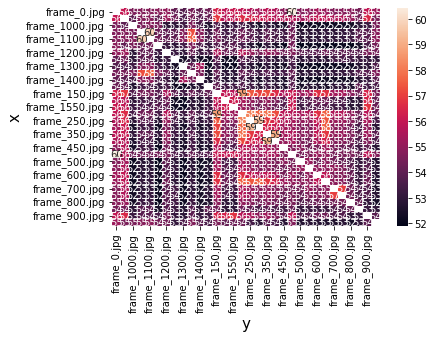

In [7]:
#Build some nice plots for better evaluation
#Select one metric and pivot the dataframe for creating the heatmap plot

df = pd.DataFrame()
for pair in combinations(comparison_images.keys(), 2):
    #print(pair)
    #*pair : instead handing over a tuple(a,b) , hand over each element as separate argument a,b
    df = compare(df, *pair, comparison_images[pair[0]], comparison_images[pair[1]], all_metrics)
    
plot_df = df[df.metric == 'sre'].pivot('x', 'y', 'value')
ax = sns.heatmap(plot_df, annot=True)

In [8]:
def select_keyframes(comparison_images: Dict[str,np.ndarray], max_keyframes: int) -> List[np.ndarray]:
    
    compare_options = list(combinations(comparison_images.keys(), max_keyframes))
    compare_df = pd.DataFrame()
    
    #Calculate and accumalate the values on all 2-combinations of each 4-tuple
    #(frame_0, frame_13, frame_60, frame_115)
    # metric(frame_0,frame_13) + metric(frame_0,frame_60) +...
    for option in compare_options:
        value = 0.0
        for x, y in combinations(option, 2):
            #get the value of the current combination and square it
            #add to the final value of the 4-tuple
            value += plot_df[x][y] ** 2

        compare_df = compare_df.append({"option": option, "value": value}, ignore_index=True)

    # select the 4-tuple with lowest metric value as keyframes
    keyframes = list(compare_df.sort_values(by=['value'], ascending=True).iloc[0].option)
    
    return keyframes


In [9]:
keyframes = select_keyframes(comparison_images, max_keyframes)


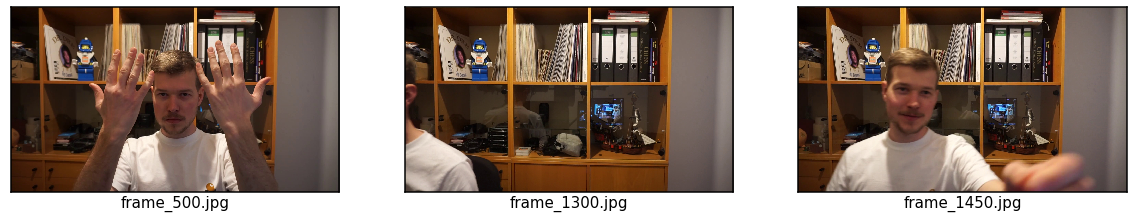

In [10]:
#for img_name in keyframes:
#    cv2.imwrite(img_name, comparison_images[img_name])
    
xlen = len(keyframes)
fig, axes = plt.subplots(1, xlen)
fig.set_size_inches(20,10)
for ax, img_path in zip(axes, keyframes):
    img = Image.open(img_path)
    isns.imgplot(img, ax=ax, cbar=False)
    ax.invert_yaxis()
    ax.set_xlabel(img_path)